# NYC Restaurant Finder
### Find Top Restaurants in the NYC based on Health & Safety Inspection Records
__Search for your Favorite Cuisine in your Area Now!__

__Author: Tarun Gupta  
  Company: Insight Data Science  
  Location: Toronto, ON__   
  Date: February 2019  
  Github: https://github.com/tguptaMT/TOPicks  
  __About:__ Find Top Restaurants for your Location and Favorite Cuisine in the NYC based on Health & Safety Inspection Records

### Import Dependencies

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.simplefilter("ignore")

### Define Functions

In [2]:
def best_rest(cuisine='Indian', zipcode='nyc', num_rest=10):
    """
    Inputs:
        Cuisine: Type of cuisine (string; default: Indian) 
        Zipcode: Zipcode within NYC (string: default: All of NYC)
        num_rest: Number of Restaurants (default: 10)
    """
    if zipcode=='nyc':
        zip_bool = True
    else:
        zip_bool = data['ZIPCODE'].astype(int) == int(zipcode)
    cuisine_bool = data['Cuisine'].str.contains(cuisine, case=False) # Default: Indian food unless specified otherwise by the user.
    best_rest = data[zip_bool & cuisine_bool].sort_values(by='SCORE')[['Restaurants', 'ZIPCODE', 'SCORE']][:num_rest]
    return best_rest

### Load Data

In [3]:
data_list = []
for file in glob.glob('data/*.txt'):
    data_list.append(pd.read_csv(file, index_col=0))
data = pd.concat(data_list, axis=0)
data.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
66653,50009775,VIANNELY RESTAURANT,BROOKLYN,250,WYCKOFF AVE,11237.0,7184973262,Spanish,08/26/2016,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,19.0,B,08/26/2016,08/28/2017,Cycle Inspection / Re-inspection
66654,41421941,DUNKIN' DONUTS,QUEENS,8209,153 AVENUE,11414.0,7183232892,Donuts,04/21/2015,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,22.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
66655,50003915,BOCAITO CAFE & WINE BAR,QUEENS,8115,NORTHERN BLVD,11372.0,3476171606,Spanish,05/18/2015,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,30.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
66656,50002654,HOMEMADE TAQUERIA,QUEENS,7103,GRAND AVE,11378.0,7187790771,Mexican,08/18/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,34.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
66657,41722182,BLANK CAFE,BROOKLYN,25,BROADWAY,11249.0,3478896975,CafÃ©/Coffee/Tea,09/30/2015,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,13.0,A,09/30/2015,08/28/2017,Cycle Inspection / Initial Inspection


### Exploratory Data Analysis and Cleaning

In [4]:
print("Number of unique restaurants: {}".format(len(data.CAMIS.unique())))  # CAMIS = unique establishment ID.
print("Number of unique Cuisines: {}".format(len(data['CUISINE DESCRIPTION'].unique())))
print("Types of Violation Codes: {}".format(len(data['VIOLATION CODE'].unique())))
print("Number of locations by Zipcode: {}".format(len(data['ZIPCODE'].unique())))

Number of unique restaurants: 26505
Number of unique Cuisines: 84
Types of Violation Codes: 98
Number of locations by Zipcode: 234


In [5]:
# Basic description of dataset:
## Shape of the dataframe:
print("Dataset has {} rows and {} features".format(data.shape[0], data.shape[1]))
print("Features include:\n",data.dtypes)

Dataset has 399918 rows and 18 features
Features include:
 CAMIS                      int64
DBA                       object
BORO                      object
BUILDING                  object
STREET                    object
ZIPCODE                  float64
PHONE                     object
CUISINE DESCRIPTION       object
INSPECTION DATE           object
ACTION                    object
VIOLATION CODE            object
VIOLATION DESCRIPTION     object
CRITICAL FLAG             object
SCORE                    float64
GRADE                     object
GRADE DATE                object
RECORD DATE               object
INSPECTION TYPE           object
dtype: object


In [6]:
# Check for duplicates:
print("There are {} duplicate rows in the data.".format(data.duplicated(keep='first').sum()))
# remove duplicates:
data.drop_duplicates(subset=None, keep='first', inplace=True)

There are 11 duplicate rows in the data.


CAMIS                         0
DBA                         359
BORO                          0
BUILDING                    109
STREET                        9
ZIPCODE                       9
PHONE                         5
CUISINE DESCRIPTION           0
INSPECTION DATE               0
ACTION                     1135
VIOLATION CODE             6504
VIOLATION DESCRIPTION      6974
CRITICAL FLAG                 0
SCORE                     23207
GRADE                    204494
GRADE DATE               207087
RECORD DATE                   0
INSPECTION TYPE            1135
dtype: int64


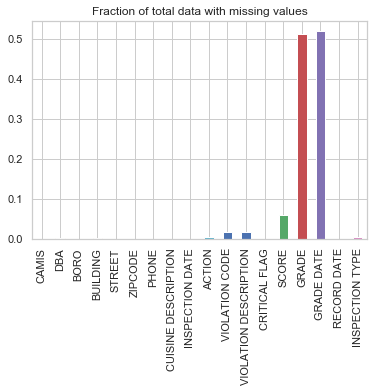

In [7]:
# Check for missing values:
print(data.isna().sum())
display(round((data.isna().sum()/(len(data))), 4).plot(kind='bar', title="Fraction of total data with missing values"))

- Almost half of all data is missing the Grade values. So, I can't really throw away the rows with missing Grades. It appears inspection score is more relevant here. Understand the difference between Grades and Scires and remove columns related to grade.
- Remove rows with missing values in 'BUILDING' instaed of imputing fillers as there aren't that many missing.
- Missing "Action" represents that these establishments have not yet been inspected. Since, the perspective I am taking on this project is to build a customer-facing restaurant warning/recommender system that suggests the best option given a set of options, it's critical to have had the inspections done on these establishments.  
- Having the names of the restaurants is important as that's how eventually customers will be searching for data for those restaurants. So, if establishment names are missing or if they haven't yet been inspected, remove those rows from the dataset. 

In [8]:
# There are QUITE A LOT of Grades missing. Understand the difference between SCORE and GRADE:
print("Grade Types: ", data.GRADE.unique())
print("SCORES:\n", data.SCORE.describe())

Grade Types:  ['B' nan 'A' 'Z' 'C' 'P' 'Not Yet Graded']
SCORES:
 count    376700.000000
mean         18.910138
std          12.959017
min          -2.000000
25%          11.000000
50%          15.000000
75%          24.000000
max         151.000000
Name: SCORE, dtype: float64


Shape of procesed DF:  (376603, 14)
CAMIS                       0
DBA                         0
BORO                        0
BUILDING                    0
STREET                      0
ZIPCODE                     0
CUISINE DESCRIPTION         0
INSPECTION DATE             0
ACTION                      0
VIOLATION CODE           1580
VIOLATION DESCRIPTION    1925
CRITICAL FLAG               0
SCORE                       0
INSPECTION TYPE             0
dtype: int64


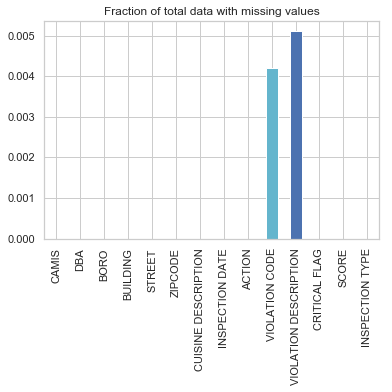

In [9]:
data.dropna(axis=0, subset=['DBA', 'ACTION', 'SCORE', 'BUILDING', 'STREET'], inplace=True)
data.drop(columns=['GRADE', 'GRADE DATE', 'RECORD DATE', 'PHONE'], inplace=True)
print("Shape of procesed DF: ", data.shape)
print(data.isna().sum())
display(round((data.isna().sum()/(len(data))), 4).plot(kind='bar', title="Fraction of total data with missing values"))

__Missing Violations could simply mean that there were no violations at all at that establishment. However, that information is encoded in the Actions column. So, check if the actions value validates that conjecture.__

In [10]:
data[data['VIOLATION CODE'].isna()==True][['ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION']]

,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION
67033,No violations were recorded at the time of thi...,NaN,NaN
67156,No violations were recorded at the time of thi...,NaN,NaN
67191,No violations were recorded at the time of thi...,NaN,NaN
67302,No violations were recorded at the time of thi...,NaN,NaN
67525,No violations were recorded at the time of thi...,NaN,NaN
67850,No violations were recorded at the time of thi...,NaN,NaN
67898,No violations were recorded at the time of thi...,NaN,NaN
68110,No violations were recorded at the time of thi...,NaN,NaN
68487,Establishment re-opened by DOHMH,NaN,NaN
68797,No violations were recorded at the time of thi...,NaN,NaN


__That validated my speculation. Missing values in Violations columns reflect that fact either no violations were found or the establishment was reopened.__ Impute "no violations" for NAN. 

In [11]:
data['VIOLATION DESCRIPTION'].fillna("no violations", inplace=True)
data['VIOLATION CODE'].fillna("no violations", inplace=True)

In [12]:
data.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,INSPECTION TYPE
66653,50009775,VIANNELY RESTAURANT,BROOKLYN,250,WYCKOFF AVE,11237.0,Spanish,08/26/2016,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,19.0,Cycle Inspection / Re-inspection
66654,41421941,DUNKIN' DONUTS,QUEENS,8209,153 AVENUE,11414.0,Donuts,04/21/2015,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,22.0,Cycle Inspection / Initial Inspection
66655,50003915,BOCAITO CAFE & WINE BAR,QUEENS,8115,NORTHERN BLVD,11372.0,Spanish,05/18/2015,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,30.0,Cycle Inspection / Initial Inspection
66656,50002654,HOMEMADE TAQUERIA,QUEENS,7103,GRAND AVE,11378.0,Mexican,08/18/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,34.0,Cycle Inspection / Initial Inspection
66657,41722182,BLANK CAFE,BROOKLYN,25,BROADWAY,11249.0,CafÃ©/Coffee/Tea,09/30/2015,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,13.0,Cycle Inspection / Initial Inspection


#### Do Inspection scores vary by the seriousness of violation?

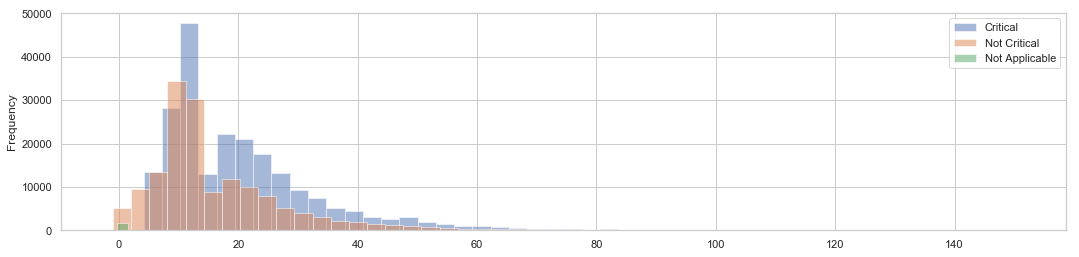

In [13]:
for each in data['CRITICAL FLAG'].unique():
    data[data['CRITICAL FLAG'] == each].SCORE\
    .plot(figsize=(18, 4), kind='hist', bins=50, alpha=0.5, label=each)
plt.legend()

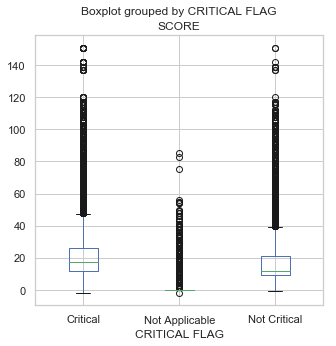

In [14]:
fig, ax0 = plt.subplots(figsize=(5, 5))
data.boxplot(column='SCORE', by='CRITICAL FLAG',ax=ax0) # without outliers: showfliers=False

- The median score for critical violation appears higher than the median score for non-critical violations.  
- It appears that inspections that don't lead to any kind of violations receive very low score. Validate that hunch by looking at Action values for critical flag == NA.

In [15]:
data[data['CRITICAL FLAG'] == 'Not Applicable'][['CRITICAL FLAG', 'VIOLATION CODE', 'SCORE']].head(10)

,CRITICAL FLAG,VIOLATION CODE,SCORE
67033,Not Applicable,no violations,0.0
67156,Not Applicable,no violations,0.0
67191,Not Applicable,no violations,0.0
67302,Not Applicable,no violations,0.0
67525,Not Applicable,no violations,0.0
67850,Not Applicable,no violations,0.0
67898,Not Applicable,no violations,0.0
68110,Not Applicable,no violations,0.0
68487,Not Applicable,no violations,0.0
68797,Not Applicable,no violations,0.0


__Ok! This validated my hunch that restaurants with no violations get a score of 0. Restaurants with violations get higher scores.__

#### How do Inspection scores vary by location (Borough and Zip Code)?

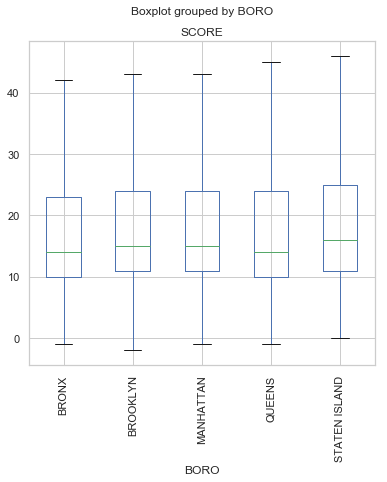

In [16]:
data.boxplot(column='SCORE', by='BORO', figsize=(6, 6), showfliers=False, rot=90)  

There isn't much difference in Inspection scores by the Borough. Explore differences by Zip Code:

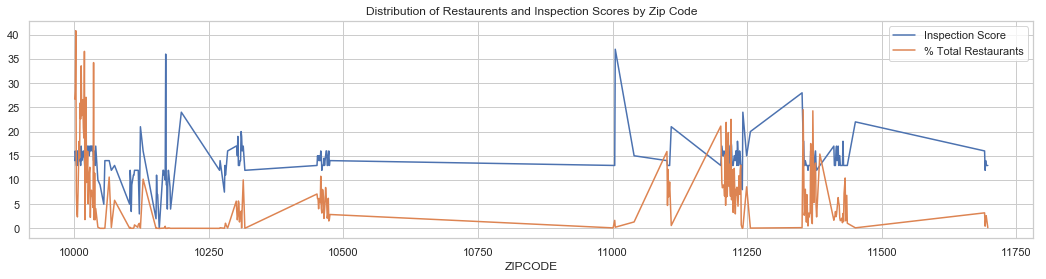

In [17]:
# Convert dtype for Zipcode:
data['ZIPCODE'] = data['ZIPCODE'].fillna(0).astype(int)
data.groupby(['ZIPCODE'])['SCORE'].median().plot(figsize=(18, 3), label='Inspection Score');
(data.groupby(['ZIPCODE'])['CAMIS'].count()*100/len(data.CAMIS.unique())).plot(figsize=(18, 4), label='% Total Restaurants');
plt.legend();
plt.title("Distribution of Restaurents and Inspection Scores by Zip Code");

__There's quite a bit of variation in the distribution of restaurents as well as their inspection scores across different zipcodes.__ Some zipcodes have very few relative number of restaurents but relatively high Inspection scores indicative of disproportionate number of violations in that area.

#### How do Inspection scores vary by Cuisine?

In [18]:
# Extract non-redundant cuisine descriptions:
import re
all_cuisines = []
for x in data['CUISINE DESCRIPTION'].unique():
    x = re.sub(r'\([^)]*\)', '', x)
    x = re.sub(r'([^a-zA-Z]+)', ' ', x)
    all_cuisines.append("|".join([y for y in x.split()[0:2] if y not in all_cuisines]))
all_cuisines = set(x for x in all_cuisines if len(x)>1)

In [19]:
# Make sure that cuisine descriptions are unique.
data['Cuisine'] = None
for each in all_cuisines:
    data.at[data['CUISINE DESCRIPTION'].str.contains(each, case=False), 'Cuisine'] = each
data['Cuisine'].unique()

array(['Spanish', 'Donuts', 'Mexican', 'Caf|Coffee', 'Italian', 'French',
       'Caribbean', 'American', 'Chicken', 'Thai', 'Hamburgers', 'Salads',
       'Pizza', 'Chinese', 'Bakery', 'Jewish|Kosher', 'Vegetarian',
       'Sandwiches', 'Cuban', 'Delicatessen', 'Indian', 'Soul|Food',
       'Irish', 'Peruvian', 'Russian', 'Vietnamese|Cambodian', 'Japanese',
       'African', 'Eastern|European', 'Continental', 'Ethiopian',
       'Korean', 'Mediterranean', 'Tex|Mex', 'Asian', 'Steak', 'Pretzels',
       'Ice|Cream', 'Tapas', 'Scandinavian', 'German', 'English',
       'Turkish', 'Pancakes|Waffles', 'Other', 'Barbecue', 'Bangladeshi',
       'Greek', 'Brazilian', 'Juice|Smoothies', 'Hotdogs', 'Filipino',
       'Chilean', 'Moroccan', 'Polish', 'Pakistani', 'Armenian', 'Cajun',
       'Hawaiian', 'Portuguese', 'Egyptian', 'Indonesian', 'Creole',
       'Soups', 'Australian', 'Afghan', 'Nuts|Confectionary',
       'Southwestern', 'Czech', 'Fruits|Vegetables', 'Iranian',
       'Polynesian

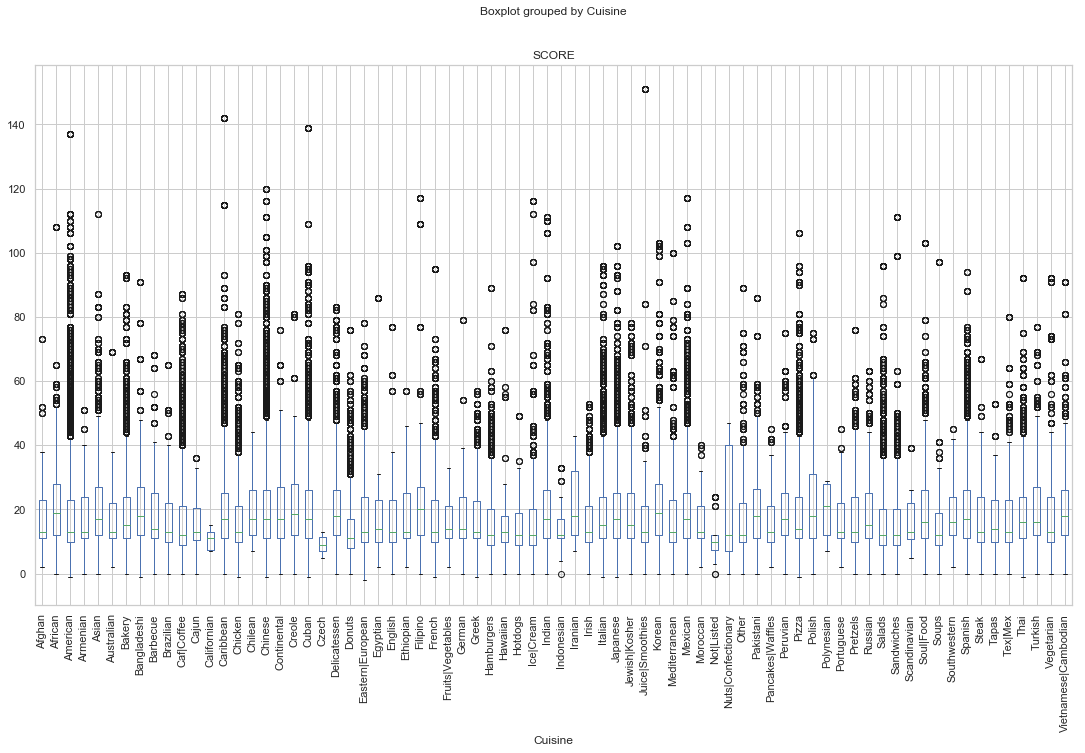

In [20]:
data.boxplot(column='SCORE', by='Cuisine', figsize=(18, 10), showfliers=True, rot=90)  

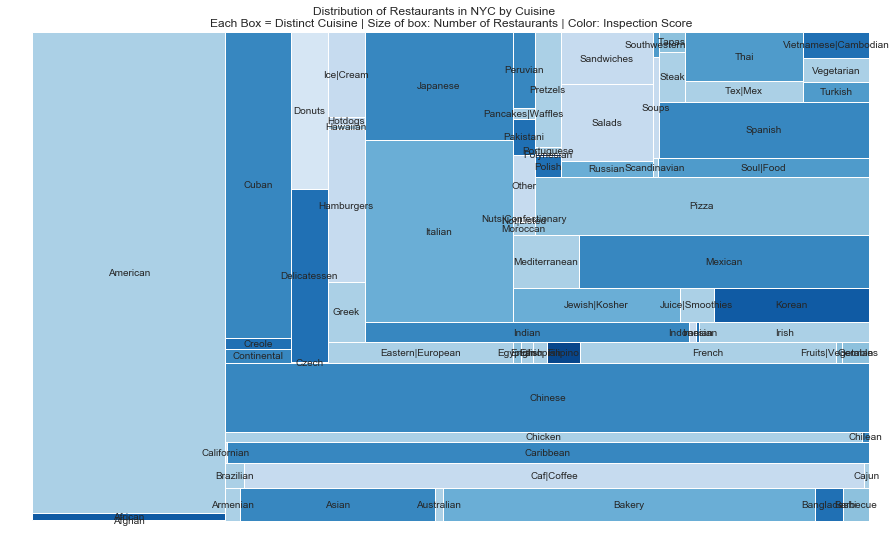

In [21]:
# Size by Counts; Color by Inspection Score

import squarify
import matplotlib
rest_counts = data.groupby(['Cuisine'])['CAMIS'].count()
med_score = data.groupby(['Cuisine'])['SCORE'].median().astype(int)

cmap = matplotlib.cm.Blues
mini=min(med_score)
maxi=max(med_score)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in med_score]

plt.rc('figure', figsize=(15, 9));
display(squarify.plot(sizes=rest_counts, norm_x=1, norm_y = 1, alpha=1, color=colors, label=med_score.index));
plt.title("Distribution of Restaurants in NYC by Cuisine\
          \nEach Box = Distinct Cuisine | Size of box: Number of Restaurants | Color: Inspection Score");
plt.axis('off');
plt.show();

Darker colors correspond to higher Scores == worse violations. Size of the box correspond to the number of restaurants for that cuisine.

### Find Best Restaurants by Cuisine and Area:

In [22]:
# Convert inspection date to datetime object
data['INSPECTION DATE'] = pd.to_datetime(data['INSPECTION DATE'], format='%m/%d/%Y')
data['INSPECTION DATE'].head()

66653   2016-08-26
66654   2015-04-21
66655   2015-05-18
66656   2017-08-18
66657   2015-09-30
Name: INSPECTION DATE, dtype: datetime64[ns]

In [23]:
# There are multiple inspections for each establishment. 
## Extract information for only the most recent inspection scores:

data = data.loc[data.groupby('CAMIS')['INSPECTION DATE'].idxmax()][
                                                            ['DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'Cuisine', 
                                                            'INSPECTION DATE', 'SCORE', 'VIOLATION DESCRIPTION']]
data.rename(columns={"DBA": "Restaurants"}, inplace=True)
data.head()

,Restaurants,BUILDING,STREET,ZIPCODE,Cuisine,INSPECTION DATE,SCORE,VIOLATION DESCRIPTION
123432,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,10462,Bakery,2017-05-18,7.0,"Food contact surface not properly washed, rins..."
91902,WENDY'S,469,FLATBUSH AVENUE,11225,Hamburgers,2017-06-26,7.0,Filth flies or food/refuse/sewage-associated (...
80636,DJ REYNOLDS PUB AND RESTAURANT,351,WEST 57 STREET,10019,Irish,2017-07-27,26.0,"Raw, cooked or prepared food is adulterated, c..."
128920,RIVIERA CATERERS,2780,STILLWELL AVENUE,11224,American,2017-07-20,13.0,Plumbing not properly installed or maintained;...
146837,BRUNOS ON THE BOULEVARD,8825,ASTORIA BOULEVARD,11369,American,2017-08-19,10.0,Food not protected from potential source of co...


## User IO:

In [25]:
cuisine = input("What kind of you cuisine are you thinking?:  ").lower().strip()
zipcode = input("Enter NYC Zipcode, or just 'NYC' for the whole city:  ").lower().strip()
num_rest = 10

best_rest(cuisine, zipcode, num_rest)

,Restaurants,ZIPCODE,SCORE
312139,V-NAM CAFE,10009,0.0
9989,HANCO'S,11201,0.0
27340,BONMi VIETNAMESE RESTAURANT,10010,2.0
8197,NEW HOME VIETNAMESE SANDWICH & BUBBLE TEA,11215,2.0
234959,V CAFE,10013,2.0
270397,CHAO CHAO,10009,2.0
133033,CO BA RESTAURANT,10011,4.0
252384,THAI SON,10013,4.0
132602,THAI SON,11373,5.0
118365,BRICOLAGE,11217,5.0
